# Project 36: Gender image categorization using NNs
### Authors: Miguel Ángel Blanco Fernández

-*Objectives*: Predict the gender **(man or woman)** in a database with a large number of images of human faces using an restricted Restricted Boltzmann Machine to find the features and a multi-layer Perceptron to classify the problem using the extracted features.  
-*What is done in the Notebook*: In this notebook we have to use a database with the images of woman and man faces. With this database we will **propose the representation or the classifier**, **implement the solution of the classification problem** and **evaluate the results of the classifier**.

# Table of Contents
1. [Importing the libraries](#1.-Importing-the-libraries)
2. [Checking the database](#2.-Checking-the-database)
3. [Preprocessing of the data and extracting the features](#3.-Preprocessing-of-the-data-and-extracting-the-features)
4. [Definition and learning of the classifier](#4.-Definition-and-learning-of-the-classifier)
5. [Evaluation of the accuracy](#5.-Evaluation-of-the-accuracy)

## 1. Importing the libraries
We import the libraries that we will use for this project.

In [14]:
# To treating and representation of the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters
from skimage.transform import resize
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

# To extracting the features of the images data
from sklearn.neural_network import BernoulliRBM

# To preprocess of the data
from sklearn.model_selection import train_test_split as train_test_split

# The supervised classifier
from sklearn.neural_network import MLPClassifier

## 2. Checking the database
Before starting with the approach of the problem, we check the data contained in the database.

In [15]:
data = pd.read_csv('a943287.csv') # Reading of the database
display(data) # Printing data of the database

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50
...,...,...,...,...,...,...,...,...,...,...
64079,1023379621,True,golden,171,NaN,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/16...,male,1616299
64080,1023379637,True,golden,174,NaN,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/15...,male,1591396
64081,1023379644,True,golden,188,NaN,unsure,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/89...,unsure,89369
64082,1023379660,True,golden,182,NaN,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/95...,male,950922


As we see checking the data in the database, we conclude that the data we will need from it will be the ones that provide us the genres of the people of the images (which will be the **class variable**) and the images (from where we will get the **features**). So, our next step will be prepare those data removing the unclassified elements.

In [16]:
values = data.values # Casting the database in an array
del_index = [] # Using an array to store the indices of the elements that we don't want in the database
for i in range(len(data.values)):
    # We attach the indices for which the column of 'gender' is a unknown data
    if values[i][5] != 'male' and values[i][5] != 'female':
        del_index.append(i)

# We take the data that interests us from the database for the problem with 2 arrays (one for the url images and other for the genders) removing the elements where the 'gender' column had unknown data
im_members = np.delete(data['image_url'].values, del_index)
genders = np.delete(data['please_select_the_gender_of_the_person_in_the_picture'].values, del_index)
print("Removed", len(del_index), "elements of the arrays with unknown gender data.")

Removed 9122 elements of the arrays with unknown gender data.


## 3. Preprocessing of the data and extracting the features
After the removing of the unclassified data, the next step will be preprocess the two arrays with the relevant data for this problem and extracting the features of the images data using an **Restricted Boltzmann Machine**.

In [17]:
"""
Method that returns a two dimensional array with the data of the images binarized and an array with the indices
of those images in the database that could not be accessed. 
"""
def ims2databinarized(images):
    binarized = [] # The two dimensional array that stores all the data of the images binarized
    error = [] # The array with the indices of images that could not be accessed
    for i in range(len(images)): # We go through each image of the urls array
        try:
            image = resize(io.imread(im_members[i]), (30, 30)) # Reading each image resized to 30x30 as an third dimensional array (RGB)
                
            gray = color.rgb2gray(image) # Converting the array of the RGB image to an array with the same size but with the channel dimension removed (two dimensional array)
            thresh = filters.threshold_otsu(gray) # The upper threshold value of the gray image array represented as a float
            binary = np.concatenate((gray >= thresh)*1) # Binarizing the gray image array with boolean data, casting to int and converting the two dimensional image binarized array in an one dimensional image binarized array
        
            binarized.append(binary) # Appending the image binarized array
            if i%1000 == 0:
                print("Binarized", i, "images", datetime.datetime.now().time())
            
        except:
            error.append(i) # If we can't read an image of the array of urls, we append his index
                
    return binarized, error

The method **ims2databinarized** is responsible for returning an array with the data of all binarized images and an array with indices of the error images. The reason for binarizing the images is because we have to use the RBM to extracting the features of the images data later and the RBM has binary visible and hidden units.

In [18]:
imp_data, error  = ims2databinarized(im_members)

Binarized 0 images 20:48:02.616158
Binarized 1000 images 20:56:29.172422
Binarized 2000 images 21:05:31.250924
Binarized 3000 images 21:15:10.596543
Binarized 4000 images 21:25:45.809338
Binarized 5000 images 21:34:29.273811
Binarized 6000 images 21:44:41.651108
Binarized 7000 images 21:54:47.453047
Binarized 8000 images 22:04:41.061157
Binarized 9000 images 22:15:01.274583
Binarized 10000 images 22:24:14.846223
Binarized 11000 images 22:35:02.197223
Binarized 12000 images 22:43:41.611764
Binarized 13000 images 22:53:57.143074
Binarized 14000 images 23:04:26.332475
Binarized 15000 images 23:13:00.046003
Binarized 16000 images 23:23:06.866074
Binarized 17000 images 23:32:08.251698
Binarized 18000 images 23:41:53.122605
Binarized 19000 images 23:50:09.761809
Binarized 20000 images 23:59:33.894055
Binarized 21000 images 00:08:48.366889
Binarized 22000 images 00:17:56.681098
Binarized 23000 images 00:28:21.183206
Binarized 24000 images 00:37:49.637205
Binarized 25000 images 00:46:20.337714

One example of the process of binarization that we do in one image of the database respect the original image resized would be seen like this.

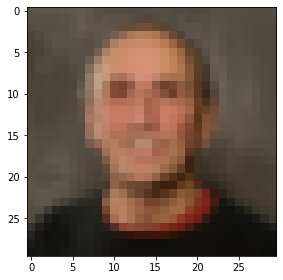

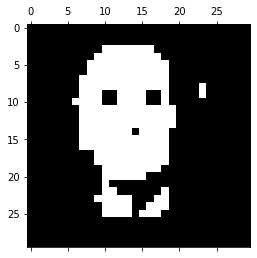

In [19]:
io.imshow(resize(io.imread(im_members[0]), (30, 30)))
plt.matshow(imp_data[0].reshape(30,30), cmap=plt.cm.gray,)
plt.show()

The class variable that we has for now, it's composed by two classes **male** and **female**. But for the classification problem, we need it with numerical data representing the two classes of this problem.

In [20]:
"""
0 = Male
1 = Female
"""
for i in range(len(genders)): # We go through each of genders people array
    if genders[i] == 'male':
        genders[i] = 0 # We assign 0 if the person is male
    elif genders[i] == 'female':
        genders[i] = 1 # We assign 1 if the person is female

y = np.delete(genders, error).astype(int) # Removing the elements corresponding to images with error when accessing them

At this point with the binarized images array prepared, the next step will be the learning of the **Restricted Boltzmann Machine**. For this task we use 50 iterations, an learning rate of 0.1 and 150 hidden layers (which means we will get 150 features for each picture that we will use for predict the gender). This neural network has only two layers: the visible layer (in this case the images) and the hidden layers (that ultimately become information about useful features if training is successful).

In [21]:
rbm = BernoulliRBM(n_components=150, verbose=True, learning_rate=0.1, n_iter=50)
rbm.fit(imp_data)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -546.02, time = 35.27s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -579.83, time = 53.72s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -576.67, time = 39.09s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -579.01, time = 39.23s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -545.13, time = 39.16s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -546.95, time = 38.87s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -552.12, time = 38.53s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -514.95, time = 37.87s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -521.16, time = 38.08s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -492.39, time = 39.03s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -526.20, time = 38.73s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -518.89, time = 38.87s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -522.33, time = 38.83s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -524.90, time = 38.26s
[

BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=150, n_iter=50,
             random_state=None, verbose=True)

With the model fitted, we can access to the hidden layer by calling the components attribute and converts them to images to see the 150 features identified by our RBM.

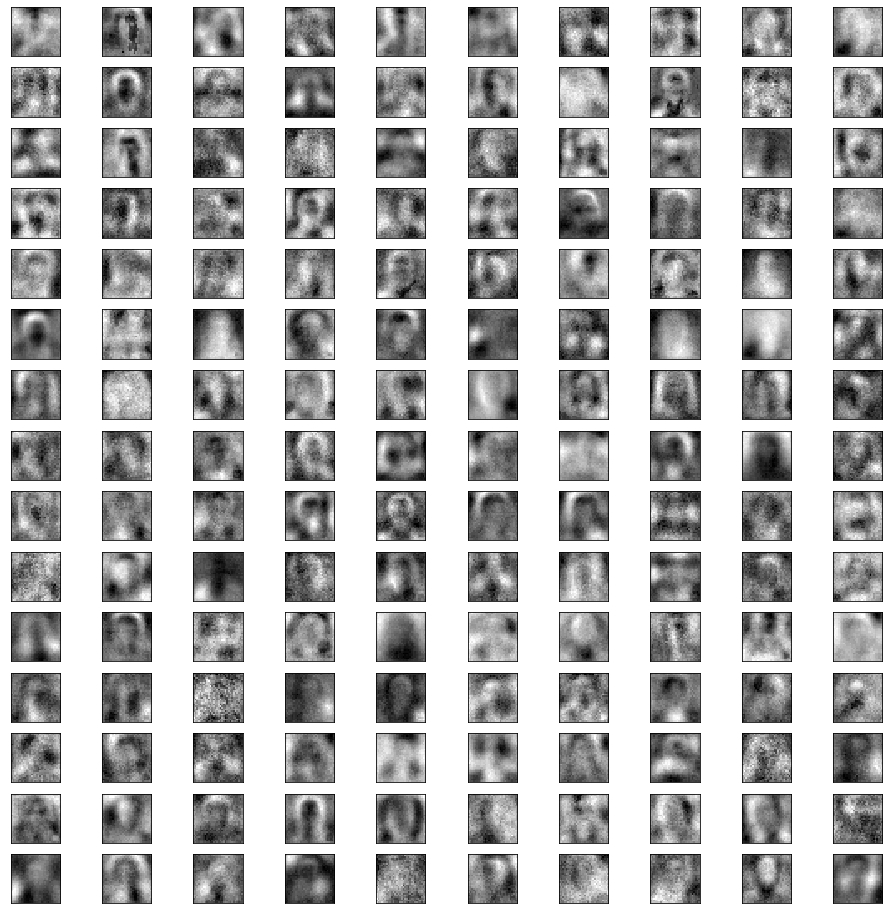

In [22]:
plt.figure(figsize=(15, 15))
for i, comp in enumerate(rbm.components_[:150]):
    plt.subplot(15, 10, i + 1)
    plt.imshow(comp.reshape((30, 30)), cmap=plt.cm.gray_r,
        interpolation='nearest')    
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

After the learning of the RBM, we take the latent variables producted by the RBM that correspond to the extracted features that we will use for the classification problem.

In [23]:
X = rbm.transform(imp_data) # Returns the latent variables

With the features extracted and the class variable in order, the next step will be create the **training data** and the **testing data** for the classfier that we will use. For the **training data** we will use an 70% of the original data and an 30% for the **testing data**.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# We check if all the data has been taken as we wanted
print("X train:", X_train.shape)
print("Y train:", y_train.shape)
print()
print("X test:", X_test.shape)
print("Y test:", y_test.shape)

X train: (37569, 150)
Y train: (37569,)

X test: (16102, 150)
Y test: (16102,)


## 4. Definition and learning of the classifier
The classifier that we've chosen for this task is the **Multi-layer Perceptron** classifier. That classification algorithm has differences between other classification algorithms such as Support Vectors Machine or Naive Bayes Classifier because the MLPClassifier relies on an underlying Neural Network to perform the task of classification. But before the definition and the learning of our classifier, we will select some sets of the best features for create new training and testing data for evaluate the accuracy of our classifier later.

In [25]:
"""
For this step we will select the best (32, 53) features.
"""

# With feature selection k=32
fs32 = SelectKBest(f_regression, k=32)
fs32.fit(X_train, y_train)

X32_train = fs32.transform(X_train)
X32_test = fs32.transform(X_test)

# With feature selection k=53
fs53 = SelectKBest(f_regression, k=53)
fs53.fit(X_train, y_train)

X53_train = fs53.transform(X_train)
X53_test = fs53.transform(X_test)

Done the datasets with feature selection, the next step will be define the classifier and his learning. For that step we've defined 3 **Multi-Layer Perceptron** classifiers.

In [26]:
'''
Definition of the multilayer perceptron classifier
'''
mlpc = MLPClassifier(hidden_layer_sizes=(150), random_state=1)
mlpc_32 = MLPClassifier(hidden_layer_sizes=(150), random_state=1)
mlpc_53 = MLPClassifier(hidden_layer_sizes=(150), random_state=1)

'''
Learning of the multilayer perceptron classifier
'''
# With out feature selection
mlpc.fit(X_train, y_train)
pred_mplc = mlpc.predict(X_test)

# With feature selection k=32
mlpc_32.fit(X32_train, y_train)
pred_mplc32 = mlpc_32.predict(X32_test)

# With feature selection k=53
mlpc_53.fit(X53_train, y_train)
pred_mplc53 = mlpc_53.predict(X53_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## 5. Evaluation of the accuracy
And after predictions with all sets using the classifier, we evaluate their accuracy. 

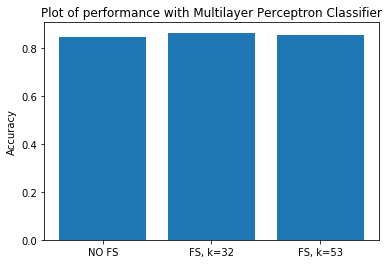

Performance with Multilayer Perceptron Classifier
-Without feature selection: 0.84
-With feature selection, k=32: 0.86
-With feature selection, k=53: 0.85


Table of performance


,Classifier,NO FS,k = 32,k = 53
0,Multilayer Perceptron,0.844553,0.862812,0.852254


In [27]:
# We take the accuracy of the classifier with the function 'score'
mlpc_sc = mlpc.score(X_test, y_test)
mlpc32_sc = mlpc_32.score(X32_test, y_test)
mlpc53_sc = mlpc_53.score(X53_test, y_test)

# Show the accuracy we've found with the classifier in a plot
height = [mlpc_sc, mlpc32_sc, mlpc53_sc]
bars = ('NO FS', 'FS, k=32', 'FS, k=53')
y_pos =np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars)

plt.title('Plot of performance with Multilayer Perceptron Classifier')
plt.ylabel('Accuracy')

plt.show()

# Show the accuracy we've found with the classifier
print("Performance with Multilayer Perceptron Classifier")
print("-Without feature selection: %0.2f" % mlpc_sc)
print("-With feature selection, k=32: %0.2f" % mlpc32_sc)
print("-With feature selection, k=53: %0.2f" % mlpc53_sc)
print()

# Show the accuracy we've found with the classifier in a table
print()
print("Table of performance")

performance = {'Classifier': ['Multilayer Perceptron'],
              'NO FS': [mlpc_sc],
              'k = 32': [mlpc32_sc],
              'k = 53': [mlpc53_sc]}

display(pd.DataFrame(performance))